<a href="https://colab.research.google.com/github/lapluu/StockPredictions/blob/main/MultivarLinearReg3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step #1 Load the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pip install keras-tuner -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.3 MB/s eta 0:00:00


In [3]:
# Time Series Forecasting - Multivariate Time Series Models for Stock Market Prediction
# A tutorial for this file is available at www.relataly.com

import math # Mathematical functions
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
from datetime import date, timedelta, datetime # Date Functions
from pandas.plotting import register_matplotlib_converters # This function adds plotting functions for calender dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import matplotlib.dates as mdates # Formatting dates
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.layers import LSTM, Dense, Dropout # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import RobustScaler, MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data
import seaborn as sns # Visualization
sns.set_style('white', { 'axes.spines.right': False, 'axes.spines.top': False})

# check the tensorflow version and the number of available GPUs
print('Tensorflow Version: ' + tf.__version__)
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

# Setting the timeframe for the data extraction
end_date =  date.today().strftime("%Y-%m-%d")
start_date = '2010-01-01'

# Getting NASDAQ quotes
# stockname = 'NASDAQ'
# symbol = '^IXIC'

stockname = 'Apple'
symbol = 'AAPL'

# You can either use webreader or yfinance to load the data from yahoo finance
# import pandas_datareader as webreader
# df = webreader.DataReader(symbol, start=start_date, end=end_date, data_source="yahoo")

import yfinance as yf #Alternative package if webreader does not work: pip install yfinance
df = yf.download(symbol, start=start_date, end=end_date)

# Create a quick overview of the dataset
df.head()

Tensorflow Version: 2.14.0
Num GPUs: 1
[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.478999,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.490201,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.386964,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.375157,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.417542,447610800


# Step #2 Exploring the Data

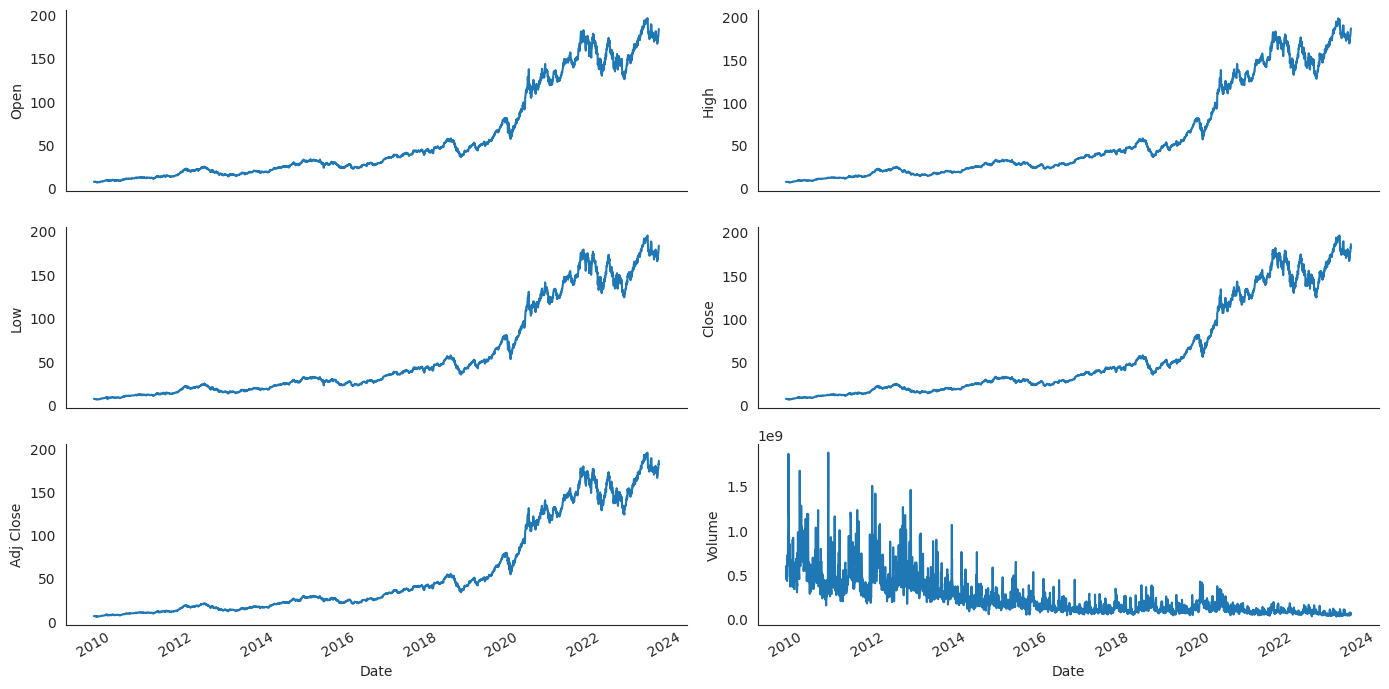

In [4]:
# Plot line charts
df_plot = df.copy()

ncols = 2
nrows = int(round(df_plot.shape[1] / ncols, 0))

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
for i, ax in enumerate(fig.axes):
        sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
        ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
fig.tight_layout()
plt.show()

# Step #3 Preprocessing and Feature Selection

In [5]:
# Indexing Batches
train_df = df.sort_values(by=['Date']).copy()

# List of considered Features
FEATURES = ['High', 'Low', 'Open', 'Close', 'Volume'
            #, 'Month', 'Year', 'Adj Close'
           ]

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pd.DataFrame(train_df)
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['High', 'Low', 'Open', 'Close', 'Volume']


,High,Low,Open,Close,Volume,Prediction
Date,,,,,,
2023-11-06,179.429993,176.210007,176.380005,179.229996,63841300,179.229996
2023-11-07,182.440002,178.970001,179.179993,181.820007,70530000,181.820007
2023-11-08,183.449997,181.589996,182.350006,182.889999,49340300,182.889999
2023-11-09,184.119995,181.809998,182.960007,182.410004,53763500,182.410004
2023-11-10,186.570007,183.529999,183.970001,186.399994,66133400,186.399994


In [6]:
data_filtered_ext.shape, data_filtered.shape


((3489, 6), (3489, 5))

In [7]:
# Get the number of rows in the data
nrows = data_filtered.shape[0]

# Convert the data to numpy values
np_data_unscaled = np.array(data_filtered)
np_data = np.reshape(np_data_unscaled, (nrows, -1))
print(np_data.shape)

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
np_data_scaled = scaler.fit_transform(np_data_unscaled)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)

(3489, 5)


In [8]:
np_data_unscaled.shape,df_Close.shape
df_Close.head()




,Close
Date,
2010-01-04,7.643214
2010-01-05,7.656429
2010-01-06,7.534643
2010-01-07,7.520714
2010-01-08,7.570714


In [9]:
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 50

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data
train_data_len = math.ceil(np_data_scaled.shape[0] * 0.8)

# Create the training and test data
train_data = np_data_scaled[0:train_data_len, :]
test_data = np_data_scaled[train_data_len - sequence_length:, :]

# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction

    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(2742, 50, 5) (2742,)
(697, 50, 5) (697,)
0.006041195233857481
0.006041195233857481


In [ ]:

data.head

<bound method NDFrame.head of                     Open          High           Low         Close  \
Date                                                                 
2010-01-04   2294.409912   2311.149902   2294.409912   2308.419922   
2010-01-05   2307.270020   2313.729980   2295.620117   2308.709961   
2010-01-06   2307.709961   2314.070068   2295.679932   2301.090088   
2010-01-07   2298.090088   2301.300049   2285.219971   2300.050049   
2010-01-08   2292.239990   2317.600098   2290.610107   2317.169922   
...                  ...           ...           ...           ...   
2023-10-23  12930.849609  13143.219727  12848.830078  13018.330078   
2023-10-24  13084.990234  13170.389648  13022.849609  13139.870117   
2023-10-25  13039.860352  13042.519531  12804.299805  12821.219727   
2023-10-26  12768.969727  12818.139648  12543.860352  12595.610352   
2023-10-27  12718.690430  12772.429688  12600.570312  12643.009766   

               Adj Close      Volume  
Date                

In [ ]:
len(x_train[0]),len(x_train[0][2]),x_train[0][0],x_train[0][0][0]

(50,
 5,
 array([0.01421756, 0.01671457, 0.01388962, 0.01551162, 0.14999877]),
 0.014217564591765375)

In [ ]:
y_train.shape

(2734,)

In [ ]:
x_train[1][49],x_train[2][49],y_train[0:20]

(array([0.02052468, 0.02295271, 0.0201116 , 0.02128795, 0.1807038 ]),
 array([0.02008359, 0.02308097, 0.02053169, 0.02144476, 0.17119922]),
 array([0.02128795, 0.02144476, 0.02023679, 0.02173976, 0.02316039,
        0.02198036, 0.02188368, 0.02172042, 0.02238135, 0.02283459,
        0.02192307, 0.02225389, 0.02418362, 0.0247049 , 0.02430033,
        0.0247049 , 0.02593936, 0.02621289, 0.02679431, 0.02957757]))

In [ ]:
x_train[0][1], x_train[1], len(x_train[1])


# Step #4 Model Training

In [42]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
#model.add(Dropout(0.1)) # new added
#model.add(LSTM(n_neurons, return_sequences=True))# new added
#model.add(LSTM(n_neurons, return_sequences=True))# new added
#model.add(Dropout(0.1))# new added
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

250 50 5


In [43]:
# Training the model
epochs = 60
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                   )

                    #callbacks=[early_stop])

Epoch 1/60
172/172 [==============================] - 6s 13ms/step - loss: 6.4896e-04 - val_loss: 0.0015
Epoch 2/60
172/172 [==============================] - 2s 9ms/step - loss: 1.4804e-04 - val_loss: 9.9207e-04
Epoch 3/60
172/172 [==============================] - 2s 12ms/step - loss: 1.0388e-04 - val_loss: 0.0029
Epoch 4/60
172/172 [==============================] - 2s 12ms/step - loss: 1.9873e-04 - val_loss: 5.5426e-04
Epoch 5/60
172/172 [==============================] - 2s 12ms/step - loss: 8.8678e-05 - val_loss: 0.0064
Epoch 6/60
172/172 [==============================] - 2s 10ms/step - loss: 9.1933e-05 - val_loss: 4.0685e-04
Epoch 7/60
172/172 [==============================] - 2s 9ms/step - loss: 7.3145e-05 - val_loss: 0.0012
Epoch 8/60
172/172 [==============================] - 2s 9ms/step - loss: 6.6395e-05 - val_loss: 8.7885e-04
Epoch 9/60
172/172 [==============================] - 2s 10ms/step - loss: 7.2952e-05 - val_loss: 4.3076e-04
Epoch 10/60
172/172 [=================

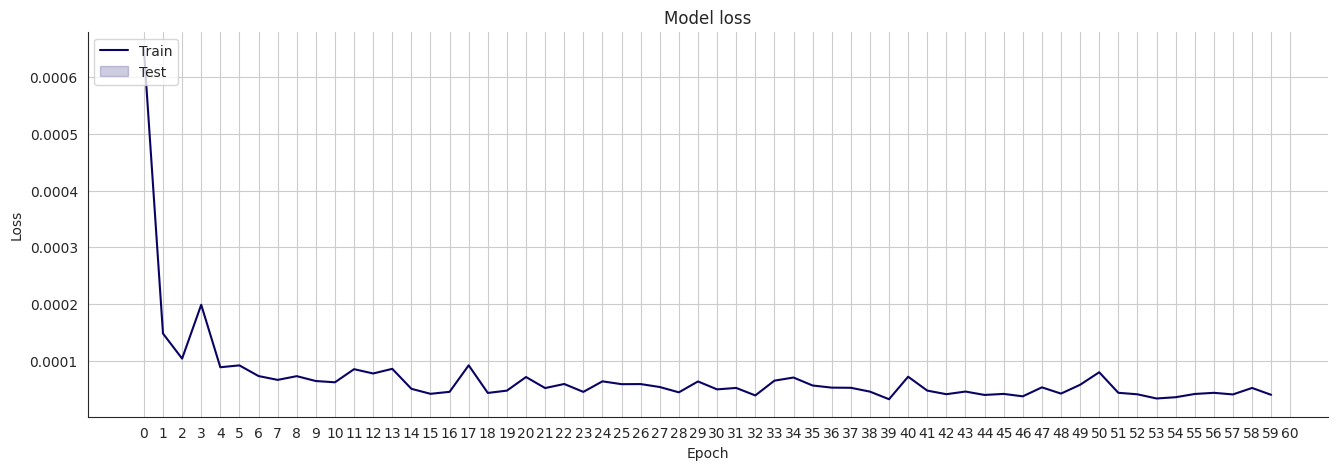

In [44]:
from matplotlib.ticker import FixedLocator

# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(16, 5), sharex=True)
sns.lineplot(data=history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
#ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
# Set ticks at every epoch
ax.xaxis.set_major_locator(FixedLocator(range(epochs + 1)))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

# Step #5 Evaluate Model Performance

In [45]:
# Get the predicted values
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

22/22 [==============================] - 1s 7ms/step
Median Absolute Error (MAE): 3.23
Mean Absolute Percentage Error (MAPE): 2.05 %
Median Absolute Percentage Error (MDAPE): 1.88 %


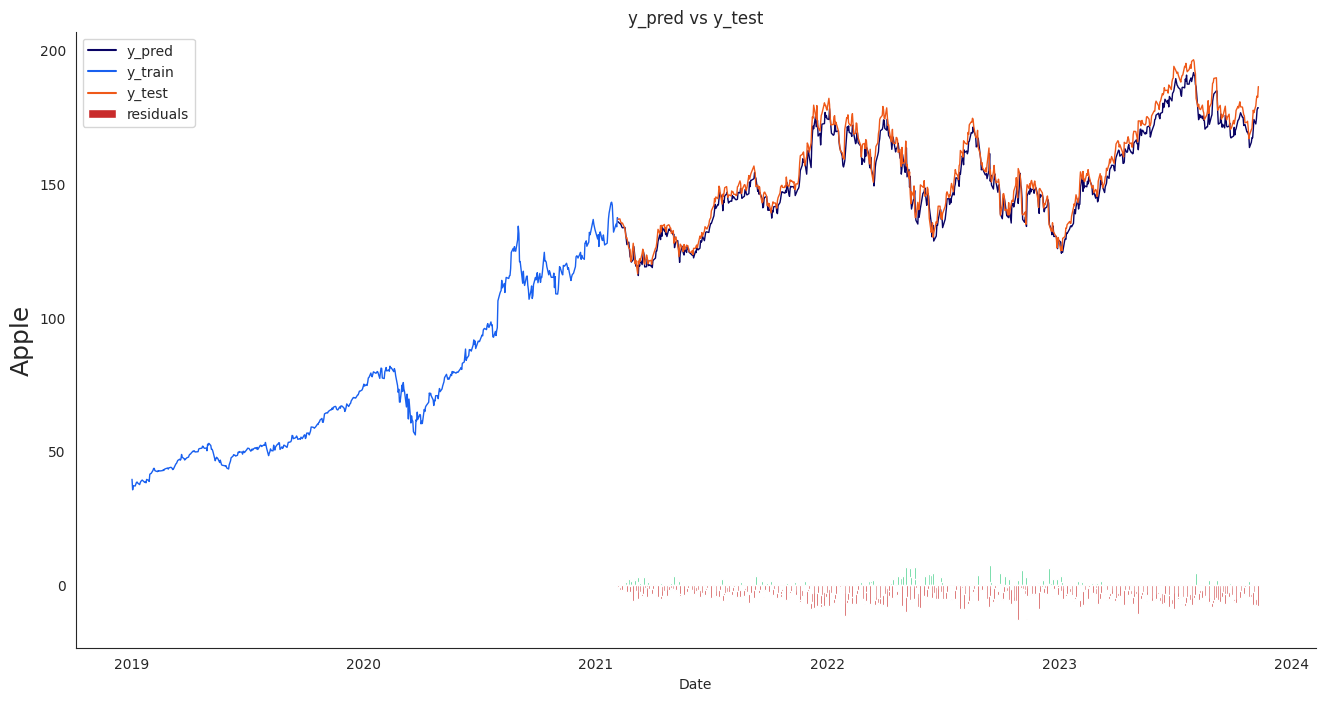

In [46]:
# The date from which on the date is displayed
display_start_date = "2019-01-01"

# Add the difference between the valid and predicted prices
train = pd.DataFrame(data_filtered_ext['Close'][:train_data_len + 1]).rename(columns={'Close': 'y_train'})
valid = pd.DataFrame(data_filtered_ext['Close'][train_data_len:]).rename(columns={'Close': 'y_test'})
valid.insert(1, "y_pred", y_pred, True)
valid.insert(1, "residuals", valid["y_pred"] - valid["y_test"], True)
df_union = pd.concat([train, valid])

# Zoom in to a closer timeframe
df_union_zoom = df_union[df_union.index > display_start_date]

# Create the lineplot
fig, ax1 = plt.subplots(figsize=(16, 8))
plt.title("y_pred vs y_test")
plt.ylabel(stockname, fontsize=18)
sns.set_palette(["#090364", "#1960EF", "#EF5919"])
sns.lineplot(data=df_union_zoom[['y_pred', 'y_train', 'y_test']], linewidth=1.0, dashes=False, ax=ax1)

# Create the bar plot with the differences
df_sub = ["#2BC97A" if x > 0 else "#C92B2B" for x in df_union_zoom["residuals"].dropna()]
ax1.bar(height=df_union_zoom['residuals'].dropna(), x=df_union_zoom['residuals'].dropna().index, width=3, label='residuals', color=df_sub)
plt.legend()
plt.show()

# Step #6 Predict Next Day's Price

In [47]:
df_temp = df[-sequence_length:]
new_df = df_temp.filter(FEATURES)

N = sequence_length

# Get the last N day closing price values and scale the data to be values between 0 and 1
last_N_days = new_df[-sequence_length:].values
last_N_days_scaled = scaler.transform(last_N_days)

# Create an empty list and Append past N days
X_test_new = []
X_test_new.append(last_N_days_scaled)

# Convert the X_test data set to a numpy array and reshape the data
pred_price_scaled = model.predict(np.array(X_test_new))
pred_price_unscaled = scaler_pred.inverse_transform(pred_price_scaled.reshape(-1, 1))

# Print last price and predicted price for the next day
price_today = np.round(new_df['Close'][-1], 2)
predicted_price = np.round(pred_price_unscaled.ravel()[0], 2)
change_percent = np.round(100 - (price_today * 100)/predicted_price, 2)

plus = '+'; minus = ''
print(f'The close price for {stockname} at {end_date} was {price_today}')
print(f'The predicted close price is {predicted_price} ({plus if change_percent > 0 else minus}{change_percent}%)')

1/1 [==============================] - 0s 22ms/step
The close price for Apple at 2023-11-11 was 186.4
The predicted close price is 182.08999633789062 (-2.37%)
